In [56]:
# ### Basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
import random

# ### Statistics
import scipy.stats as sc_stats
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, fcluster

# ### Cluster ###
from sklearn import cluster

# ### Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# ### Methods for classification
import sklearn.metrics as sk_metrics 

# ### Model selection
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

# ### Methods for regression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# ### Manifold methods
from sklearn.decomposition import PCA
import sklearn.manifold as sk_manifold

# ### For feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

warnings.filterwarnings('ignore')

import utils as ute
import ml_utils as mlute

In [2]:
pvalue_th = 0.05
seed_th = 0

In [3]:
df = pd.read_csv('Data/ProcessedData.csv')

print( "Columns name", df.columns )

print("Number of columns", df.shape[1])
print("Number of patients", df.shape[0])
print( "Data frame shape", df.shape )

Columns name Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification', 'rbc_nan', 'rbc_normal',
       'pc_nan', 'pc_normal', 'pcc_notpresent', 'ba_notpresent', 'htn_yes',
       'dm_nan', 'dm_yes', 'cad_no', 'appet_nan', 'appet_good', 'pe_no',
       'ane_no', 'age_imp_median', 'bp_imp_median', 'sg_imp_median',
       'al_imp_median', 'su_imp_median', 'bgr_imp_median', 'bu_imp_median',
       'sc_imp_median', 'sod_imp_median', 'pot_imp_median', 'hemo_imp_median',
       'pcv_imp_median', 'wc_imp_median', 'rc_imp_median', 'target'],
      dtype='object')
Number of columns 55
Number of patients 400
Data frame shape (400, 55)


## Cluster

In [4]:
features_to_use = [
    'age', 'bp', 'sg', 'al', 'su', 'bgr',
    'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc',
    'rbc_nan', 'rbc_normal',
    'pc_nan', 'pc_normal', 'pcc_notpresent', 'ba_notpresent', 'htn_yes',
    'dm_nan', 'dm_yes', 'cad_no', 'appet_nan', 'appet_good', 'pe_no',
    'ane_no'
]

clt_nona_idx = df[features_to_use].dropna().index
df_clt = df[features_to_use].dropna().reset_index(drop=True)
print("Shape", df_clt.shape)

ps_target_col = (df.loc[clt_nona_idx, "classification"] == "ckd")*1
ps_target_col = ps_target_col.reset_index(drop=True)

Shape (201, 28)


In [5]:
counter, max_iter = 0, 1 * 10 ** 3
clt_result_list = []
while True:
    
    if counter % 50 == 0:
        print("Iteration", counter, "of", max_iter, end="\r")
    
    cluster_idx = random.randint(0, 1)
    num_clusters = random.randint(2, 8)
    
    cluster_model_name = [
        "kmeans", "agglomerative"
    ]
    
    cluster_model = [
        cluster.KMeans(n_clusters=num_clusters), 
        cluster.AgglomerativeClustering(n_clusters=num_clusters, affinity="euclidean", linkage="ward")
    ]
    
    num_features = random.randint(2, len(features_to_use))
    feat_to_alg = random.choices(features_to_use, k=num_features)
    
    y_pred = cluster_model[cluster_idx].fit_predict(df_clt[feat_to_alg])
    
    nmis = sk_metrics.cluster.normalized_mutual_info_score(ps_target_col.values, y_pred)
    
    clt_result_list.append({
        "Iteration": counter,
        "Model": cluster_model_name[cluster_idx],
        "NumClusters": num_clusters,
        "Features": feat_to_alg,
        "NumFeatures": len(feat_to_alg),
        "MutualInfoScore": nmis,
    })
    
    if counter >= max_iter:
        break
    else:
        counter += 1
    

In [6]:
df_clt_result = pd.DataFrame(clt_result_list)
df_clt_result = df_clt_result.sort_values("MutualInfoScore", ascending=False).reset_index(drop=True)
df_clt_result.head(8)

,Iteration,Model,NumClusters,Features,NumFeatures,MutualInfoScore
0,894,agglomerative,2,"[hemo, su]",2,0.898968
1,885,agglomerative,2,"[hemo, pe_no, pe_no]",3,0.807461
2,958,kmeans,2,"[sg, rbc_nan, hemo, htn_yes, su, dm_yes, pc_no...",15,0.807461
3,272,agglomerative,2,"[rc, dm_yes, cad_no, appet_good]",4,0.807461
4,982,kmeans,4,"[rbc_normal, htn_yes, hemo, dm_yes, ane_no, sg...",16,0.789371
5,736,kmeans,2,"[dm_yes, rc, cad_no, pc_nan, pe_no, rbc_nan]",6,0.787637
6,791,kmeans,3,"[pot, rc, dm_nan, appet_good, hemo, pot]",6,0.772292
7,983,agglomerative,2,"[rc, rbc_nan, ba_notpresent, pc_normal, htn_ye...",10,0.768679


In [7]:
print("Best model", df_clt_result.loc[0, "Model"])
print("Number of clusters", df_clt_result.loc[0, "NumClusters"])
print("Best features", df_clt_result.loc[0, "Features"])
print("Mutual info score", np.round(df_clt_result.loc[0, "MutualInfoScore"], 4) )

Best model agglomerative
Number of clusters 2
Best features ['hemo', 'su']
Mutual info score 0.899


In [8]:
df["ClusterLabels"] = np.nan

num_clusters_th = df_clt_result.loc[0, "NumClusters"]

if df_clt_result.loc[0, "Model"] == "kmeans":
    model_clt = cluster.KMeans(n_clusters=num_clusters_th)
elif df_clt_result.loc[0, "Model"] == "agglomerative":
    model_clt = cluster.AgglomerativeClustering(n_clusters=num_clusters_th, affinity="euclidean", linkage="ward")

idx_no_nan = df[df_clt_result.loc[0, "Features"]].dropna().index
df_to_cluster = df.loc[idx_no_nan, df_clt_result.loc[0, "Features"]]

model_clt.fit(df_to_cluster)

df_to_cluster["ClusterLabels"] = model_clt.labels_

In [9]:
df["ClusterLabels"] = df_to_cluster["ClusterLabels"]

In [10]:
df_clt[df_clt_result.loc[0, "Features"]].head(5)

,hemo,su
0,11.2,0.0
1,12.2,0.0
2,9.5,0.0
3,10.8,0.0
4,9.7,1.0


In [11]:
all_top_features = []
for feat in df_clt_result["Features"].iloc[:5].to_list():
    all_top_features += feat
all_top_features_arr = np.array(all_top_features)

In [12]:
top_features = {col: np.sum(all_top_features_arr==col) for col in set(all_top_features)}
top_features = {k: v for k, v in sorted(top_features.items(), key=lambda item: item[1], reverse=True)}
top_features

{'hemo': 6,
 'htn_yes': 4,
 'cad_no': 3,
 'su': 3,
 'dm_yes': 3,
 'rc': 2,
 'rbc_nan': 2,
 'ane_no': 2,
 'appet_good': 2,
 'pe_no': 2,
 'pc_normal': 2,
 'sg': 2,
 'sc': 1,
 'al': 1,
 'appet_nan': 1,
 'pc_nan': 1,
 'pcc_notpresent': 1,
 'rbc_normal': 1,
 'pot': 1}

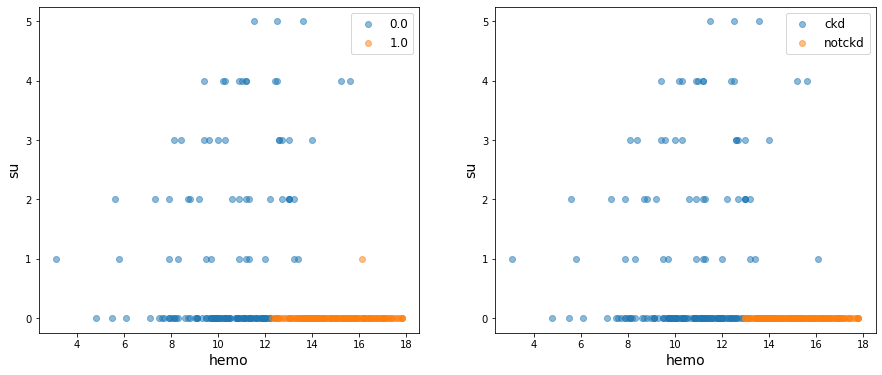

In [13]:
fig = plt.figure(figsize=(15, 6))

fig.add_subplot(1, 2, 1)
for g, df_g in df.groupby("ClusterLabels"):
    if not np.isnan(g):
        
        plt.scatter(df_g[ df_clt_result.loc[0, "Features"][0] ], 
                    df_g[ df_clt_result.loc[0, "Features"][1] ], 
                    alpha=0.5, label=str(g))

plt.legend(fontsize=12)
plt.xlabel(df_clt_result.loc[0, "Features"][0], fontsize=14)
plt.ylabel(df_clt_result.loc[0, "Features"][1], fontsize=14)

fig.add_subplot(1, 2, 2)
for g, df_g in df.groupby("classification"):
        
    plt.scatter(df_g[ df_clt_result.loc[0, "Features"][0] ], 
                df_g[ df_clt_result.loc[0, "Features"][1] ], 
                alpha=0.5, label=str(g))

plt.legend(fontsize=12)
plt.xlabel(df_clt_result.loc[0, "Features"][0], fontsize=14)
plt.ylabel(df_clt_result.loc[0, "Features"][1], fontsize=14)

plt.show()

In [14]:
100 * pd.crosstab(df["classification"], df["ClusterLabels"], normalize=True)

ClusterLabels,0.0,1.0
classification,,
ckd,47.588424,7.717042
notckd,0.000000,44.694534


### Compare cluster methods

In [15]:
columns_to_cluster = [
    'age', 'bp', 'sg', 'al', 'su', 'bgr',
    'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc',
    'rbc_nan', 'rbc_normal',
    'pc_nan', 'pc_normal', 'pcc_notpresent', 'ba_notpresent', 'htn_yes',
    'dm_nan', 'dm_yes', 'cad_no', 'appet_nan', 'appet_good', 'pe_no',
    'ane_no'
]

index_man_nona = df[columns_to_cluster].dropna().index
df_nona = df.loc[index_man_nona].reset_index(drop=True)

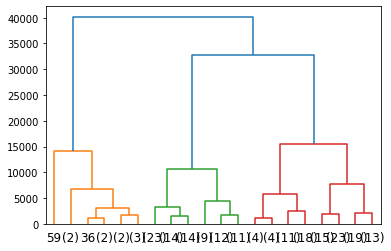

In [16]:
agg_clt = cluster.AgglomerativeClustering(n_clusters=None, affinity="euclidean", linkage="ward", distance_threshold=0)
agg_clt.fit_predict(df_nona[columns_to_cluster])

ute.plot_dendrogram(agg_clt, p=20, truncate_mode='lastp')

In [17]:
agg_clt = cluster.AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="ward")
clt_t0 = agg_clt.fit_predict(df_nona[columns_to_cluster])

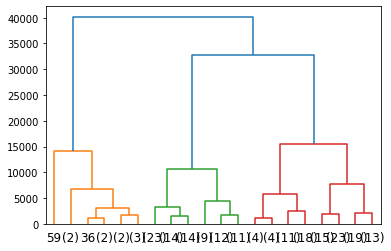

In [18]:
linked = linkage(df_nona[columns_to_cluster], method='ward', metric="euclidean")
my_dendo = hierarchy.dendrogram(linked, 20, 'lastp')
plt.show()

In [19]:
labels_scipy = fcluster(linked, t=6, criterion="maxclust")

In [20]:
pd.crosstab(labels_scipy, clt_t0)

col_0,0,1,2,3,4,5
row_0,,,,,,
1,0,0,10,0,0,0
2,0,0,0,0,1,0
3,0,0,0,0,0,51
4,0,0,0,32,0,0
5,0,37,0,0,0,0
6,70,0,0,0,0,0


In [21]:
sk_metrics.normalized_mutual_info_score(labels_scipy, clt_t0)

1.0

## Manifold

In [22]:
df_man = df.copy()

In [23]:
columns_to_manifold = [
    'age', 'bp', 'sg', 'al', 'su', 'bgr',
    'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc',
    'rbc_nan', 'rbc_normal',
    'pc_nan', 'pc_normal', 'pcc_notpresent', 'ba_notpresent', 'htn_yes',
    'dm_nan', 'dm_yes', 'cad_no', 'appet_nan', 'appet_good', 'pe_no',
    'ane_no'
]

numerical_manifold_feat = [
    'age', 'bp', 'sg', 'al', 'su', 'bgr',
    'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc'
]

boolean_manifold_feat = [
    'rbc_nan', 'rbc_normal',
    'pc_nan', 'pc_normal', 'pcc_notpresent', 'ba_notpresent', 'htn_yes',
    'dm_nan', 'dm_yes', 'cad_no', 'appet_nan', 'appet_good', 'pe_no',
    'ane_no'
]

columns_to_manifold = numerical_manifold_feat + boolean_manifold_feat

print("Number of columns", len(columns_to_manifold))

Number of columns 28


In [24]:
index_man_nona = df_man[numerical_manifold_feat].dropna().index
df_man_nona = df_man.loc[index_man_nona].reset_index(drop=True)

print("Shape of the data", df_man_nona.shape)

Shape of the data (201, 56)


In [25]:
norm_mode = "Std"

if norm_mode == "Std":
    df_man_nona_num = (
        df_man_nona[numerical_manifold_feat] - df_man_nona[numerical_manifold_feat].mean(axis=0)
    )/(df_man_nona[numerical_manifold_feat].std(axis=0))
elif norm_mode == "Minmax":
    df_man_nona_num = (
        df_man_nona[numerical_manifold_feat] - df_man_nona[numerical_manifold_feat].min(axis=0)
    )/(df_man_nona[numerical_manifold_feat].max(axis=0) - df_man_nona[numerical_manifold_feat].min(axis=0))
else:
    df_man_nona_num = df_man_nona[numerical_manifold_feat]

### PCA

In [26]:
pca = PCA(n_components=2, random_state=seed_th)
pca_array = pca.fit_transform(df_man_nona_num)

df_man_pca = pd.DataFrame(pca_array)
df_man_pca["Target"] = df_man_nona["classification"]
df_man_pca["ClusterTarget"] = df_man_nona["ClusterLabels"]
print("Explained Variance ratio in PCA", np.round(100 * np.sum(pca.explained_variance_ratio_), 4), "%")

Explained Variance ratio in PCA 55.861 %


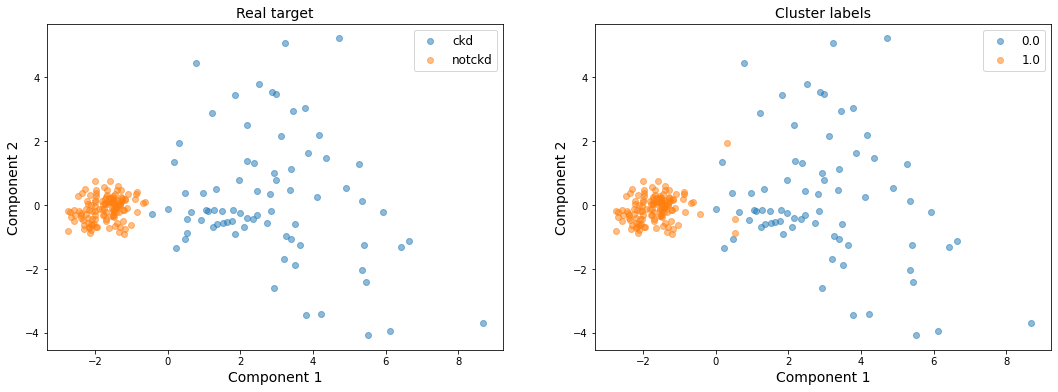

In [27]:
fig = plt.figure(figsize=(18, 6))

fig.add_subplot(1, 2, 1)
for g, df_g in df_man_pca.groupby("Target"):

    plt.scatter(df_g[0], df_g[1], label=str(g), alpha=0.5)
    
plt.legend(fontsize=12)
plt.ylabel("Component 2", fontsize=14)
plt.xlabel("Component 1", fontsize=14)
plt.title("Real target", fontsize=14)

fig.add_subplot(1, 2, 2)
for g, df_g in df_man_pca.groupby("ClusterTarget"):

    plt.scatter(df_g[0], df_g[1], label=str(g), alpha=0.5)
    
plt.legend(fontsize=12)
plt.ylabel("Component 2", fontsize=14)
plt.xlabel("Component 1", fontsize=14)
plt.title("Cluster labels", fontsize=14)

plt.show()

In [57]:
X_data = df_man_pca[[0, 1]]
Y_data = (df_man_pca["Target"] == "ckd") * 1

df_metrics_score = mlute.get_model_metrics(
    X_data, Y_data, 
    model=LogisticRegression(random_state=seed_th, n_jobs=-1), 
    n_splits=10, n_repeats=4, random_state=seed_th
)

Mean Accuracy = 0.9951 +/- 0.0148 ; Median = 1.0 ; Min. =  0.95 ; Max. =  1.0
Mean CohenKappa = 0.9893 +/- 0.0323 ; Median = 1.0 ; Min. =  0.8864 ; Max. =  1.0
Mean AUC = 0.9935 +/- 0.0195 ; Median = 1.0 ; Min. =  0.9286 ; Max. =  1.0


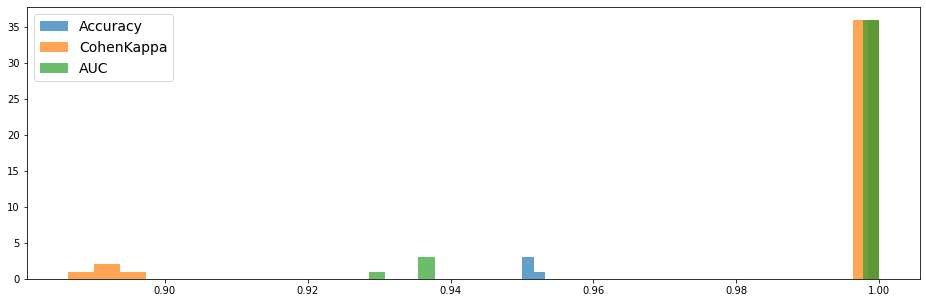

In [58]:
ute.stat_print(df_metrics_score["Accuracy"], "Accuracy")
ute.stat_print(df_metrics_score["CohenKappa"], "CohenKappa")
ute.stat_print(df_metrics_score["AUC"], "AUC")

plt.figure(figsize=(16, 5))

plt.hist(df_metrics_score["Accuracy"], bins=31, label="Accuracy", alpha=0.7)
plt.hist(df_metrics_score["CohenKappa"], bins=31, label="CohenKappa", alpha=0.7)
plt.hist(df_metrics_score["AUC"], bins=31, label="AUC", alpha=0.7)

plt.legend(fontsize=14)

plt.show()

### t-SNE

In [28]:
tsne = sk_manifold.TSNE(n_components=2, perplexity=50, random_state=seed_th, n_jobs=-1)
tsne_array = tsne.fit_transform(df_man_nona_num)

df_man_tsne = pd.DataFrame(tsne_array)
df_man_tsne["Target"] = df_man_nona["classification"]
df_man_tsne["ClusterTarget"] = df_man_nona["ClusterLabels"]

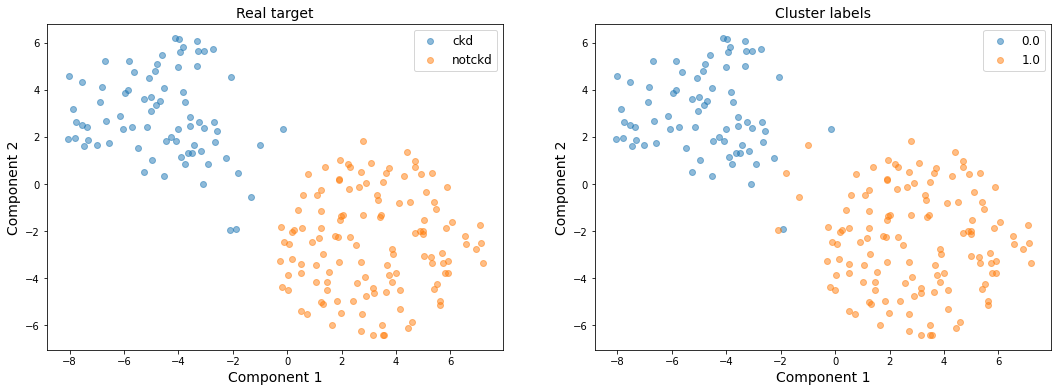

In [29]:
fig = plt.figure(figsize=(18, 6))

fig.add_subplot(1, 2, 1)
for g, df_g in df_man_tsne.groupby("Target"):

    plt.scatter(df_g[0], df_g[1], label=str(g), alpha=0.5)
    
plt.legend(fontsize=12)
plt.ylabel("Component 2", fontsize=14)
plt.xlabel("Component 1", fontsize=14)
plt.title("Real target", fontsize=14)

fig.add_subplot(1, 2, 2)
for g, df_g in df_man_tsne.groupby("ClusterTarget"):

    plt.scatter(df_g[0], df_g[1], label=str(g), alpha=0.5)
    
plt.legend(fontsize=12)
plt.ylabel("Component 2", fontsize=14)
plt.xlabel("Component 1", fontsize=14)
plt.title("Cluster labels", fontsize=14)

plt.show()

In [59]:
X_data = df_man_tsne[[0, 1]]
Y_data = (df_man_tsne["Target"] == "ckd") * 1

df_metrics_score = mlute.get_model_metrics(
    X_data, Y_data, 
    model=LogisticRegression(random_state=seed_th, n_jobs=-1), 
    n_splits=10, n_repeats=4, random_state=seed_th
)

Mean Accuracy = 1.0 +/- 0.0 ; Median = 1.0 ; Min. =  1.0 ; Max. =  1.0
Mean CohenKappa = 1.0 +/- 0.0 ; Median = 1.0 ; Min. =  1.0 ; Max. =  1.0
Mean AUC = 1.0 +/- 0.0 ; Median = 1.0 ; Min. =  1.0 ; Max. =  1.0


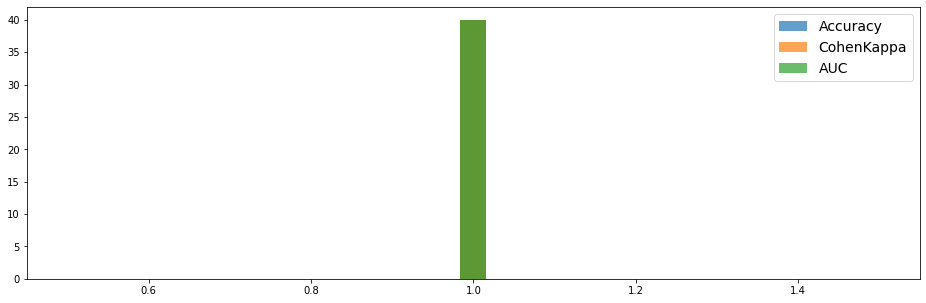

In [60]:
ute.stat_print(df_metrics_score["Accuracy"], "Accuracy")
ute.stat_print(df_metrics_score["CohenKappa"], "CohenKappa")
ute.stat_print(df_metrics_score["AUC"], "AUC")

plt.figure(figsize=(16, 5))

plt.hist(df_metrics_score["Accuracy"], bins=31, label="Accuracy", alpha=0.7)
plt.hist(df_metrics_score["CohenKappa"], bins=31, label="CohenKappa", alpha=0.7)
plt.hist(df_metrics_score["AUC"], bins=31, label="AUC", alpha=0.7)

plt.legend(fontsize=14)

plt.show()